In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from collections import defaultdict
import shutil

In [2]:
print(pickle.HIGHEST_PROTOCOL)

5


In [3]:
def find_det_coordinates(spec):
    spec = spec-5
    x_before = spec//128
    y_before = spec%128
    y_new = 127-y_before
    x_new = 152*(x_before//152) + 151 - (x_before % 152)
    return int(y_new), int(x_new) # swapped to match x,y

In [4]:
def findSpectrumIndex(indices, ntubes=1520, npix_per_tube=128, ntubes_per_bank=152, nmonitors=5):
    """
    :param indices: indices of found peaks in 3d array
    :param ntubes: number of tubes in instrument (WISH)
    :param npix_per_tube: number of detector pixels in each tube
    :param ntubes_per_bank: number of tubes per bank
    :param nmonitors: number of monitor spectra (assumed first spectra in ws)
    :return: list of spectrum indindices of workspace corresponding to indices of found peaks in 3d array
    """
    # find bank and then reverse order of tubes in bank
    ibank = np.floor(indices[:,0]/ntubes_per_bank)
    itube = ibank*ntubes_per_bank + ((ntubes_per_bank-1) - indices[:,0] % ntubes_per_bank)
    # flip tube 
    ipix = (npix_per_tube-1) - indices[:,1]
    # get spectrum index
    specIndex = np.ravel_multi_index((itube.astype(int), ipix), 
        dims=(ntubes, npix_per_tube), order='C') + nmonitors
    return specIndex.tolist()  # so elements are of type int not numpy.int32

In [5]:
def get_bins_with_peaks(labels):
    peaks_per_bin = defaultdict(list)
    for spec, bin, _, _ in labels:
        if bin in peaks_per_bin:
            if spec not in peaks_per_bin[bin]:
                peaks_per_bin[bin].append(spec)
        else:
            peaks_per_bin[bin] = [spec]
    return peaks_per_bin

In [6]:
def get_bins_with_peaks_in_full_range(ws, labels):
    """
    Consider the bins from start to end for each peak as having a peak
    """
    peaks_per_bin = defaultdict(list)
    for i_bin in range(ws.shape[2]):
        for spec, max, start, end in labels:
            if i_bin >= start and i_bin <= end:
                if i_bin in peaks_per_bin:
                    if spec not in peaks_per_bin[i_bin]:
                        peaks_per_bin[i_bin].append(spec)
                else:
                    peaks_per_bin[i_bin] = [spec]
    return peaks_per_bin

In [7]:
def save_bins_with_annotations(labels, ws, annotation_outdir, nparr_outdir, ws_index):
    # peaks_per_bin = get_bins_with_peaks(labels)
    
    peaks_per_bin = get_bins_with_peaks_in_full_range(ws, labels)
    
    bin_index = 0
    for bin, peaks in peaks_per_bin.items():
        bin_save_path = os.path.join(nparr_outdir, f"{ws_index}_{bin_index}.npz")
        np.savez_compressed(bin_save_path, ws[:,:,bin])
        annotation_data = dict()
        annotation_data["nparr_path"] = bin_save_path
        annotation_data["bin_index"] = bin
        annotation_data["peaks"] = peaks
        annotation_save_path = os.path.join(annotation_outdir, f"annot_{ws_index}_{bin_index}.pickle")
        with open(annotation_save_path, 'wb') as handle:
            pickle.dump(annotation_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        bin_index += 1

In [8]:
workspaces_dir = "/home/wj1132075/Desktop/Raw_Data/Workspaces/"
labels_dir = "/home/wj1132075/Desktop/Raw_Data/Labels/"

In [9]:
annotations_output_dir = "/home/wj1132075/Desktop/CNN_Model_Data/PeakDataInFullRange/Annotations/"
bins_output_dir = "/home/wj1132075/Desktop/CNN_Model_Data/PeakDataInFullRange/BinData/"

### Create Annotation files and save bin data

In [10]:
shutil.rmtree(annotations_output_dir), shutil.rmtree(bins_output_dir)
os.mkdir(annotations_output_dir), os.mkdir(bins_output_dir)

(None, None)

In [11]:
from tqdm.notebook import tqdm

for label_f_name in tqdm(sorted(os.listdir(labels_dir))):
    ws_index = label_f_name.split('.')[0].split('_')[-1]
    label_f_path = os.path.join(labels_dir, label_f_name)
    labels = np.loadtxt(label_f_path, delimiter=',', dtype=int)
    ws_f_name = f"workspace_{label_f_name.split('.')[0].split('_')[-1]}.npz"
    ws_f_path = os.path.join(workspaces_dir, ws_f_name)
    ws = np.load(ws_f_path)['arr_0']
    save_bins_with_annotations(labels, ws, annotations_output_dir, bins_output_dir, ws_index)

  0%|          | 0/72 [00:00<?, ?it/s]

In [12]:
labels = np.loadtxt('/home/wj1132075/Desktop/Raw_Data/Labels/labels_50.txt', delimiter=',', dtype=int)

In [13]:
ws = np.load('/home/wj1132075/Desktop/Raw_Data/Workspaces/workspace_50.npz')['arr_0']
ws.shape

(1520, 128, 1540)

In [14]:
peaks_per_bin = get_bins_with_peaks_in_full_range(ws, labels)

In [15]:
def plot_bin(bin_data, peak_spec_ids, bin_id):
    plt.figure(figsize=(6,6))
    cs = plt.contourf(bin_data)
    plt.colorbar(cs)
    for peak in peak_spec_ids:
        det_x, det_y = find_det_coordinates(peak)
        plt.plot(det_x, det_y, marker="x", markersize=5, markeredgecolor="red", markerfacecolor="red")
    plt.title(f"TOF bin:{bin_id}")
    plt.show()

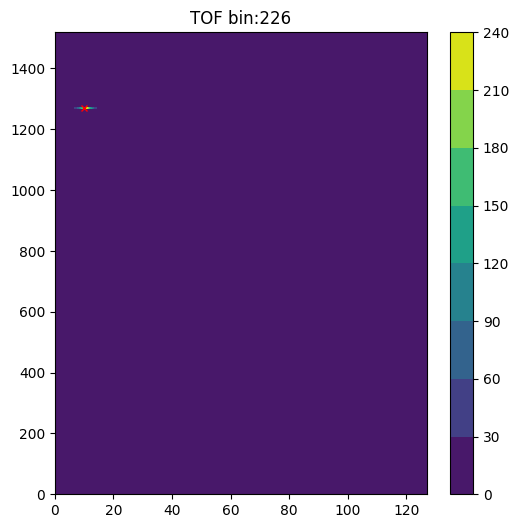

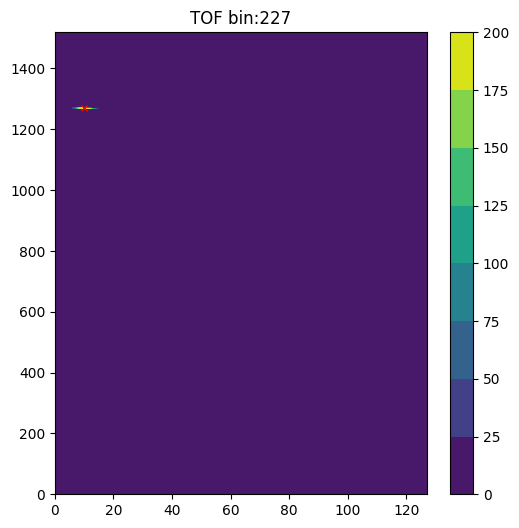

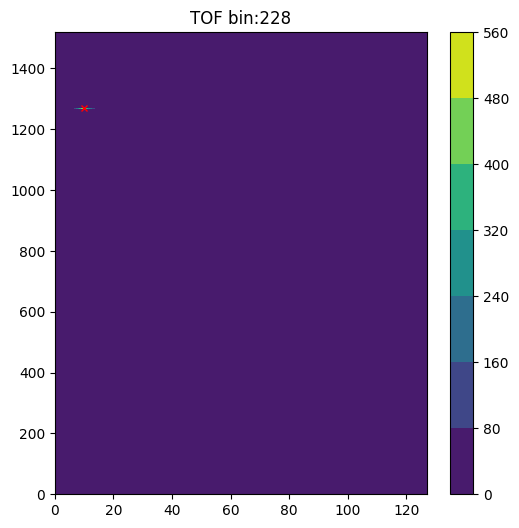

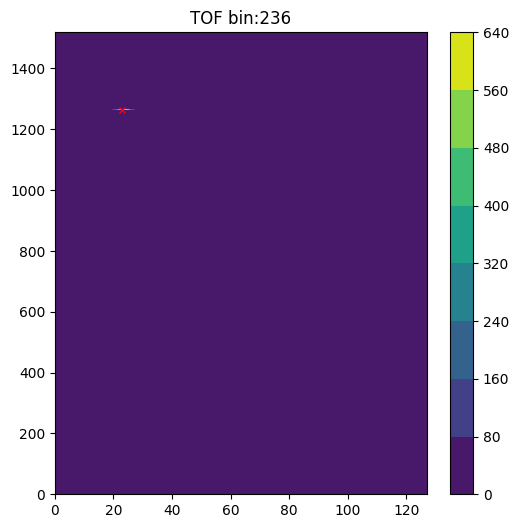

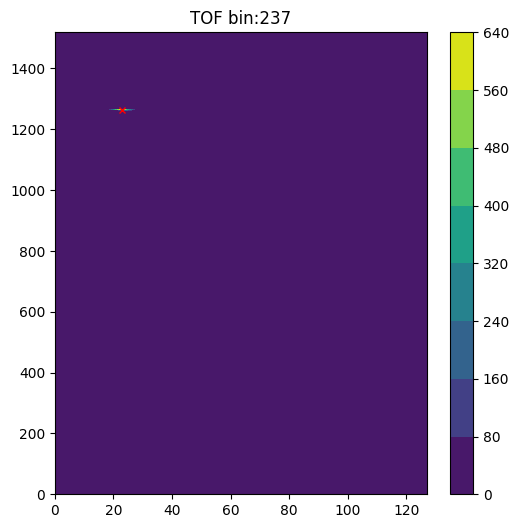

In [16]:
test = 0
for bin, peak_list in peaks_per_bin.items():
    plot_bin(ws[:,:, bin], peak_list, bin)
    test += 1
    if test == 5:
        break